# Code to generate figure 3 for the paper

In [1]:
# setup all the imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import urllib.request
import matplotlib.font_manager
flist = matplotlib.font_manager.get_font_names()
from tempfile import NamedTemporaryFile
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.patches as patches
from extremeweatherbench import evaluate, utils, cases, defaults
sns.set_theme(style='whitegrid')
from shapely.geometry import Polygon
import shapely
from pathlib import Path

# make the basepath - change this to your local path
basepath = Path.home() / 'ExtremeWeatherBench' / ''
basepath = str(basepath) + '/'

In [2]:
# %load /home/amy/ExtremeWeatherBench/docs/notebooks/figure_targets.py
import logging

import numpy as np
import xarray as xr

from extremeweatherbench import inputs, metrics

# Suppress noisy log messages
logging.getLogger("urllib3.connectionpool").setLevel(logging.CRITICAL)
logging.getLogger("botocore.httpchecksum").setLevel(logging.CRITICAL)


def _preprocess_bb_cira_forecast_dataset(ds: xr.Dataset) -> xr.Dataset:
    """An example preprocess function that renames the time coordinate to lead_time,
    creates a valid_time coordinate, and sets the lead time range and resolution not
    present in the original dataset.

    Args:
        ds: The forecast dataset to rename.

    Returns:
        The renamed forecast dataset.
    """
    ds = ds.rename({"time": "lead_time"})
    # The evaluation configuration is used to set the lead time range and resolution.
    ds["lead_time"] = np.array(
        [i for i in range(0, 241, 6)], dtype="timedelta64[h]"
    ).astype("timedelta64[ns]")
    return ds


# GHCN targets
ghcn_heatwave_target = inputs.GHCN(
    source=inputs.DEFAULT_GHCN_URI,
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={},
)

ghcn_freeze_target = inputs.GHCN(
    source=inputs.DEFAULT_GHCN_URI,
    variables=[
        "surface_air_temperature",
        "surface_eastward_wind",
        "surface_northward_wind",
    ],
    variable_mapping={
        "surface_temperature": "surface_air_temperature",
        "surface_eastward_wind": "surface_eastward_wind",
        "surface_northward_wind": "surface_northward_wind",
    },
    storage_options={},
)

# LSR and PPH targets
lsr_target = inputs.LSR(
    source=inputs.LSR_URI,
    variables=["local_storm_reports"],
    variable_mapping={},
    storage_options={"remote_options": {"anon": True}},
)

pph_target = inputs.PPH(
    source=inputs.PPH_URI,
    variables=["practically_perfect_hindcast"],
    variable_mapping={},
    storage_options={"remote_options": {"anon": True}},
)

# IBTrACS target
ibtracs_target = inputs.IBTrACS(
    source=inputs.IBTRACS_URI,
    variables=[
        "surface_wind_speed",
        "air_pressure_at_mean_sea_level",
    ],
    variable_mapping=inputs.IBTrACS_metadata_variable_mapping,
    storage_options={},
)

# Forecast Examples

cira_heatwave_forecast_FOURv2 = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=_preprocess_bb_cira_forecast_dataset,
)

cira_heatwave_forecast_GC = inputs.KerchunkForecast(
    source="gs://extremeweatherbench/GRAP_v100_GFS.parq",
    variables=["surface_air_temperature"],
    variable_mapping={"t2": "surface_air_temperature"},
    storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
    preprocess=_preprocess_bb_cira_forecast_dataset,
)

# cira_freeze_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[
#         "surface_air_temperature",
#         "surface_eastward_wind",
#         "surface_northward_wind",
#     ],
#     variable_mapping={
#         "t2": "surface_air_temperature",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
#     preprocess=_preprocess_bb_cira_forecast_dataset,
# )

# # Severe convection forecast
# cira_severe_convection_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[],
#     variable_mapping={
#         "t": "air_temperature",
#         "t2": "surface_air_temperature",
#         "z": "geopotential",
#         "r": "relative_humidity",
#         "u": "eastward_wind",
#         "v": "northward_wind",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
# )

# cira_tropical_cyclone_forecast = inputs.KerchunkForecast(
#     source="gs://extremeweatherbench/FOUR_v200_GFS.parq",
#     variables=[
#         "surface_wind_speed",
#         "air_pressure_at_mean_sea_level",
#     ],
#     variable_mapping={
#         "t": "air_temperature",
#         "t2": "surface_air_temperature",
#         "z": "geopotential",
#         "r": "relative_humidity",
#         "u": "eastward_wind",
#         "v": "northward_wind",
#         "10u": "surface_eastward_wind",
#         "10v": "surface_northward_wind",
#     },
#     storage_options={"remote_protocol": "s3", "remote_options": {"anon": True}},
# )

FOURv2_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_FOURv2, 
    ),
]

GC_EVALUATION_OBJECTS = [
    inputs.EvaluationObject(
        event_type="heat_wave",
        metric_list=[
            metrics.MaximumMAE,
            metrics.RMSE,
            metrics.OnsetME,
            metrics.DurationME,
            metrics.MaxMinMAE,
        ],
        target=ghcn_heatwave_target,
        forecast=cira_heatwave_forecast_GC, 
    ),
]


In [3]:
# load in all of the events in the yaml file
case_dict = utils.load_events_yaml()
heat_test = {"cases": case_dict["cases"][0:2]}

ewb_fourv2 = evaluate.ExtremeWeatherBench(heat_test, FOURv2_EVALUATION_OBJECTS)
ewb_gc = evaluate.ExtremeWeatherBench(heat_test, GC_EVALUATION_OBJECTS)

This function is deprecated and will be removed in a future release. Please use cases.load_ewb_events_yaml_into_case_collection instead.
This function is deprecated and will be removed in a future release. Please use cases.read_incoming_yaml instead.


In [4]:
heat_test

{'cases': [{'case_id_number': 1,
   'title': '2021 Pacific Northwest',
   'start_date': datetime.datetime(2021, 6, 20, 0, 0),
   'end_date': datetime.datetime(2021, 7, 3, 0, 0),
   'location': {'type': 'centered_region',
    'parameters': {'latitude': 47.6062,
     'longitude': 237.6679,
     'bounding_box_degrees': 5}},
   'event_type': 'heat_wave'},
  {'case_id_number': 2,
   'title': '2022 Upper Midwest',
   'start_date': datetime.datetime(2022, 5, 7, 0, 0),
   'end_date': datetime.datetime(2022, 5, 17, 0, 0),
   'location': {'type': 'centered_region',
    'parameters': {'latitude': 41.8781,
     'longitude': 272.3702,
     'bounding_box_degrees': 5}},
   'event_type': 'heat_wave'}]}

In [5]:
fourv2_results = ewb_fourv2.run(pre_compute=True)
gc_results = ewb_gc.run(pre_compute=True)

No number of jobs provided, using joblib backend default.


  0%|          | 0/2 [00:00<?, ?it/s]

Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}
No number of jobs provided, using joblib backend default.


  0%|          | 0/2 [00:00<?, ?it/s]

forecast dataset for case 1 has zero-length dimensions ['valid_time'] for case time range 2021-06-20 00:00:00 to 2021-07-03 00:00:00
Missing expected columns: {'lead_time'}
Missing expected columns: {'lead_time'}


In [6]:
fourv2_results

,value,lead_time,target_variable,metric,target_source,forecast_source,case_id_number,event_type
0,0.971132,0 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,1,heat_wave
1,6.565706,0 days 06:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,1,heat_wave
2,2.958956,0 days 12:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,1,heat_wave
3,6.811037,0 days 18:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,1,heat_wave
4,3.50757,1 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,1,heat_wave
...,...,...,...,...,...,...,...,...
409,NaN,9 days 00:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
410,NaN,9 days 06:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
411,NaN,9 days 12:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
412,NaN,9 days 18:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave


In [11]:
gc_results

,value,lead_time,target_variable,metric,target_source,forecast_source,case_id_number,event_type
0,1.885016,0 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
1,1.94483,0 days 06:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
2,1.961279,0 days 12:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
3,2.4401,0 days 18:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
4,1.921576,1 days 00:00:00,surface_air_temperature,MaximumMAE,GHCN,kerchunk_forecast,2,heat_wave
...,...,...,...,...,...,...,...,...
276,NaN,9 days 00:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
277,NaN,9 days 06:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
278,NaN,9 days 12:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave
279,NaN,9 days 18:00:00,surface_air_temperature,MaxMinMAE,GHCN,kerchunk_forecast,2,heat_wave


In [ ]:
# grab only the maximum MAE results for the heat wave
max_mae_results_fourv2 = fourv2_results[(fourv2_results['metric'] == 'MaximumMAE') & (fourv2_results['case_id_number'] == 2)]
max_mae_results_gc = gc_results[(gc_results['metric'] == 'MaximumMAE') & (gc_results['case_id_number'] == 2)]



In [21]:
max_mae_results_fourv2['value'].values

array([5.015295075717006, 1.359655427279506, 2.705511140170131,
       1.895269440951381, 2.821996735873256, 1.205816315951381,
       2.113775300326381, 2.430761384310756, 3.387975739779506,
       1.833013581576381, 2.691869782748256, 1.810216950717006,
       2.381933259310756, 0.8577023022795061, 0.9317379468107561,
       0.7448788159513811, 0.9180660718107561, 0.9742184155607561,
       0.7587948315763811, 0.6182919018888811, 1.059087800326381,
       0.38953213626388106, 1.114996003451381, 0.06247525149825606,
       1.007513093295131, 0.6914309985017439, 0.17612271243575606,
       0.07788662845138106, 1.143011140170131, 0.43636508053299394,
       0.12222866946700606, 0.23758511477950606, 0.9550533764982561,
       2.191045808138881, 2.289800690951381, 0.37888150149825606,
       0.8596859448576311, 1.902471589388881, 3.726263093295131,
       4.972021149935756, 6.770086335482631], dtype=object)

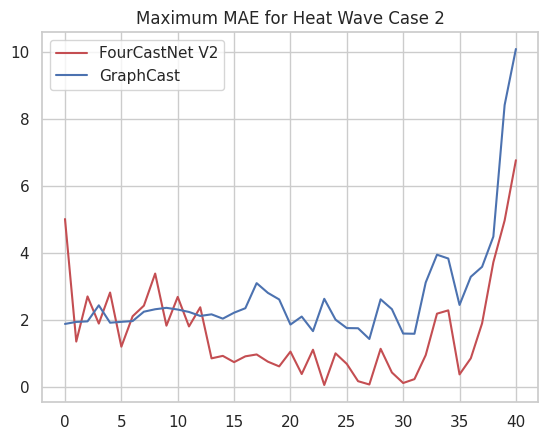

In [25]:
plt.plot(max_mae_results_fourv2['value'].values, 'r', label='FourCastNet V2')
plt.plot(max_mae_results_gc['value'].values, 'b', label='GraphCast')
plt.title('Maximum MAE for Heat Wave Case 2')
plt.legend()